# Project 2 - Advanced Methods in Applied Statistics 2024 - Emilie Jessen

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy 
from iminuit import Minuit

In [4]:
# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
mpl.rc('font', **font)

axes = {'facecolor': 'ghostwhite'}
mpl.rc('axes', **axes)

# Add grid
mpl.rc('axes', grid=True)

# Set custom color cycle
custom_colors= ['dodgerblue', 'red', 'limegreen', 'orange', 'orchid', 'black', 'slategrey', 
                'navy', 'magenta', 'forestgreen', 'lightblue', 'maroon', 'gold', 'lightcoral', 
                'mediumseagreen', 'darkorange', 'darkviolet', 'dimgray', 'darkblue', 'darkred',]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

# Set inside tickmarks
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True

In [5]:
save_plots = False

# Exercise 1a

# Exercise 1b

# Exercise 2

In [6]:
# Loading the data 
data = pd.read_csv('cpd-crash-incidents.csv', delimiter=';', header=0, usecols=["lon", "lat", 'crash_date'])

# Negative longitude implies ‘West’, whereas positive implies ‘East’ from a spot in
# Greenwich Park in London, England

# Exercise 2a

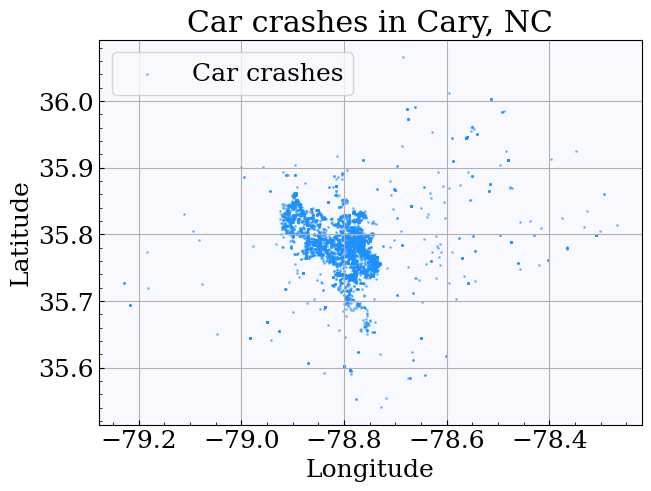

In [7]:
# Scatter plot of the car crashes, as a function of longitude and latitude

fig, ax = plt.subplots(figsize=(7, 5))

ax.scatter(data['lon'], data['lat'], s=1, alpha=0.5, label='Car crashes')
ax.set(xlabel='Longitude', 
       ylabel='Latitude', 
       title='Car crashes in Cary, NC')

ax.legend()

if save_plots:
       plt.savefig('car_crashes_cary.png', dpi=300)

In [8]:
# Histogram of the car crashes, as a function of the time of day (in hours)

# Extracting the hour and minutes of the day from the crash_date
data['crash_date'] = pd.to_datetime(data['crash_date'])
data['time_hour'] = data['crash_date'].dt.hour + data['crash_date'].dt.minute/60

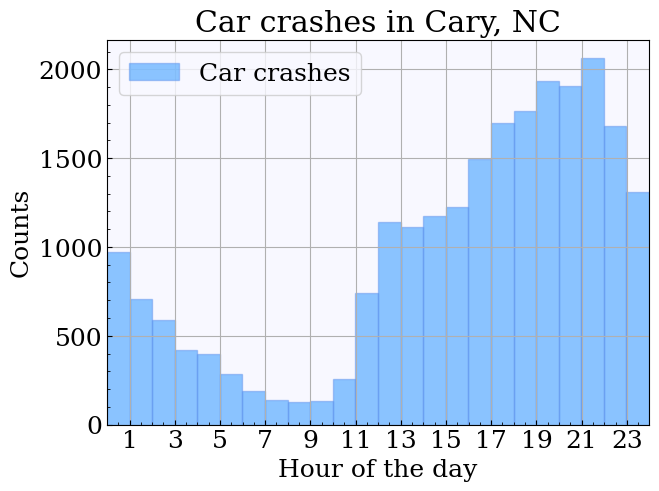

In [9]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.hist(data['time_hour'], bins=24, alpha=0.5, edgecolor='cornflowerblue', label='Car crashes')
ax.set(xlabel='Hour of the day', 
       ylabel='Counts', 
       title='Car crashes in Cary, NC', 
       xticks=np.arange(1, 25, 2),
       xlim=(0, 24))


ax.legend()

if save_plots:
         plt.savefig('car_crashes_cary_hour.png', dpi=300)

In [10]:
# Describe how would you create a kernel density estimation using a gaussian
# kernel with a bandwidth of 0.25 hours to produce a probability density function
# of the time of day for crashes

#N.B. For a 24-hour clock, time ‘wraps’ at 00:00 & 24:00. For example, 00:01 and 23:59 are
#very close to each other in actual time, but not numerically.

# Kernel density estimation (KDE) is a non-parametric way to estimate the probability density function of a random variable.
# The kernel function is a non-negative function that integrates to one and has a mean of zero.
# The bandwidth parameter controls the smoothness of the estimated density. A large bandwidth will produce a smoother density,
# but it will also smooth out the true underlying density. A small bandwidth will produce a density estimate that is closer to the true density, but it will also be more noisy.

# The Gaussian kernel is a popular choice for KDE, and it is defined as:
# K(x) = (1/sqrt(2*pi)) * exp(-x^2/2)

# The kernel density estimate is then given by:
# f(x) = (1/nh) * sum(K((x-xi)/h))

# where n is the number of data points, h is the bandwidth, and K is the kernel function.



# Exercise 2b 

In [11]:
# Create a kernel density estimation using an Epanechnikov kernel with a bandwidth of
# 0.8 hours to produce a probability density function of the time of day for crashes

def epanechnikov_kernel(u, h):
    """Function to calculate the Epanechnikov kernel"""

    if np.abs(u) <= 1:
        return 3 / 4 * (1 - u**2)
    else:
        return 0
    
def KDE(data, point, h, kernel):
    """Function to calculate the kernel density estimate"""

    N = len(data)
    u = (point - data)

    # Ensure the wrapping of the data is considered, i.e. we want 12 hours on each side
    u[u > 12] -= 24 
    u[u < -12] += 24
    u /= h

    KDE = 1 / (N * h) * np.sum(np.array([kernel(i, h) for i in u]))

    return KDE

In [12]:
N_points = 24 * 60
t_axis = np.linspace(0, 24, N_points)
h = 0.8

# Create the kernel density estimate

KDE_epanechnikov = np.array([KDE(data['time_hour'], t, h, epanechnikov_kernel) for t in t_axis])

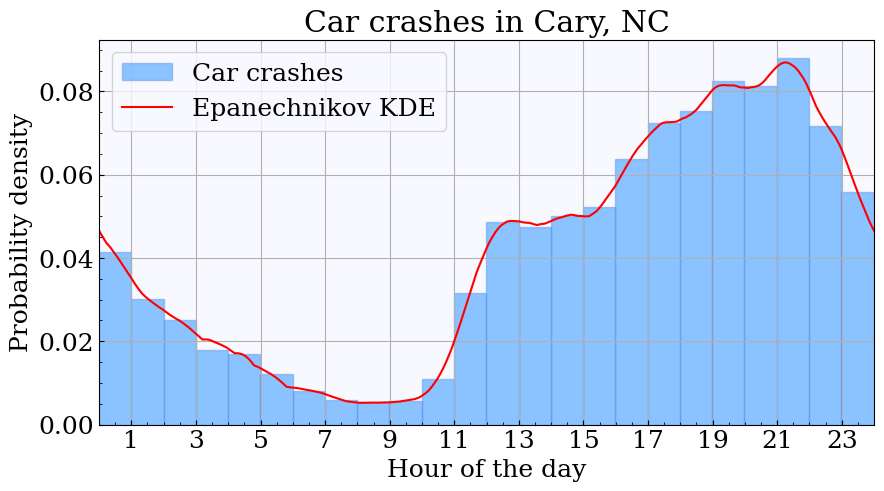

In [13]:
# Plot the KDE

fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(data['time_hour'], bins=24, alpha=0.5, edgecolor='cornflowerblue', label='Car crashes', density=True)
ax.plot(t_axis, KDE_epanechnikov, label='Epanechnikov KDE')
ax.set(xlabel='Hour of the day', 
       ylabel='Probability density', 
       title='Car crashes in Cary, NC', 
       xticks=np.arange(1, 25, 2),
       xlim=(0, 24))

ax.legend()

if save_plots:
    plt.savefig('car_crashes_cary_KDE.png', dpi=300)

KDE for 0:23: 0.0422
KDE for 1:49: 0.0284
KDE for 8:12: 0.0052
KDE for 15:55: 0.0565
KDE for 18:02: 0.0733
KDE for 21:12: 0.0869
KDE for 23:44: 0.0510


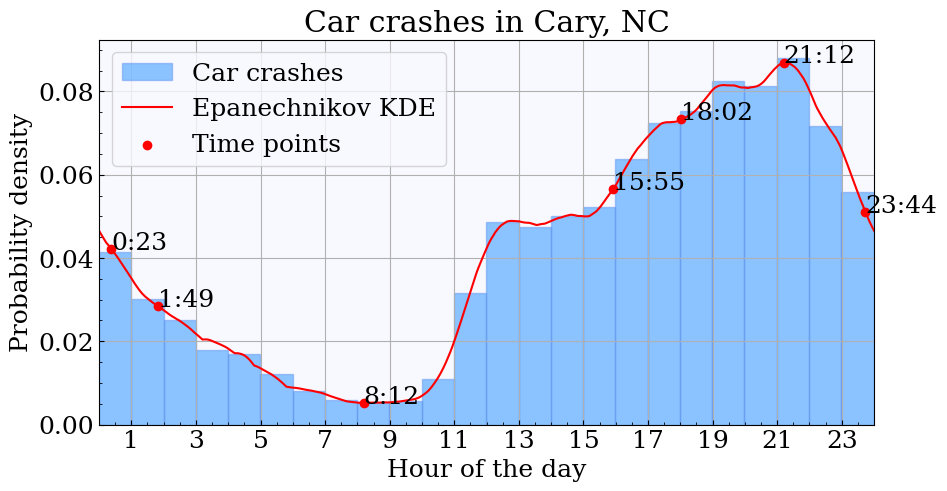

In [59]:
# Defining the time points from the assignment
hours = np.array([0, 1, 8, 15, 18, 21, 23])
minutes = np.array([23, 49, 12, 55, 2, 12, 44])

time_points = hours + minutes/60

# KDE for the time points
KDE_epanechnikov_points = np.array([KDE(data['time_hour'], t, h, epanechnikov_kernel) for t in time_points])

# Print the KDE for the time points
for i in range(len(hours)):
    if minutes[i] < 10:
        print(f'KDE for {hours[i]}:0{minutes[i]}: {KDE_epanechnikov_points[i]:.4f}')
    else:
        print(f'KDE for {hours[i]}:{minutes[i]}: {KDE_epanechnikov_points[i]:.4f}')


# Plot the KDE and the time points
        
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(data['time_hour'], bins=24, alpha=0.5, edgecolor='cornflowerblue', label='Car crashes', density=True)
ax.plot(t_axis, KDE_epanechnikov, label='Epanechnikov KDE')
ax.scatter(time_points, KDE_epanechnikov_points, color='red', label='Time points')
ax.set(xlabel='Hour of the day', 
       ylabel='Probability density', 
       title='Car crashes in Cary, NC',
       xticks=np.arange(1, 25, 2),
       xlim=(0, 24))

# Plot the time points
for i in range(len(hours)):
    if minutes[i] < 10:
        ax.text(time_points[i], KDE_epanechnikov_points[i], f'{hours[i]}:0{minutes[i]}')
    else:
        ax.text(time_points[i], KDE_epanechnikov_points[i], f'{hours[i]}:{minutes[i]}')

ax.legend()

if save_plots:
    plt.savefig('car_crashes_cary_KDE_points.png', dpi=300)

In [15]:
# KDE PDF describes the relative crash likelihood during a 24-hour window
# If additional police patrolled the entire 24-hour time, then there would be a 10% decrease in the likelihood of accidents
# So what is the percentage of the 24-hour daily crashes that will be reduced by your 2-hour window?

window = 2 * 60         # 2-hour window
t_cyclic = np.concatenate((t_axis, t_axis[:window]))  # Add the overlapping part

KDE_epanechnikov_cyclic = np.concatenate((KDE_epanechnikov, KDE_epanechnikov[:window]))
KDE_decreased = KDE_epanechnikov_cyclic * 0.9     # 10% decrease in the likelihood of accidents

dt = np.diff(t_axis)[0]
total_KDE_integral = np.trapz(KDE_epanechnikov, dx=dt)  # Total integral of the KDE

reduction = np.zeros(N_points)

for i in range(N_points):
    end = i + window
    KDE_integral = np.trapz(KDE_epanechnikov_cyclic[i:end], dx=dt)
    KDE_decreased_integral = np.trapz(KDE_decreased[i:end], dx=dt)
    reduction[i] = (KDE_integral - KDE_decreased_integral) / total_KDE_integral * 100

In [17]:
# Find the maximum reduction

max_reduction = np.max(reduction)
max_reduction_time_start = t_axis[np.argmax(reduction)]
max_reduction_time_end = t_axis[np.argmax(reduction) + window]

print(f'The maximum reduction of {max_reduction:.2f}% occurs between') 
print(f'{int(max_reduction_time_start):.0f}:{(max_reduction_time_start*60) % 60:.0f} and {int(max_reduction_time_end):.0f}:{(max_reduction_time_end*60) % 60:.0f} hours')

The maximum reduction of 1.66% occurs between
19:58 and 21:58 hours


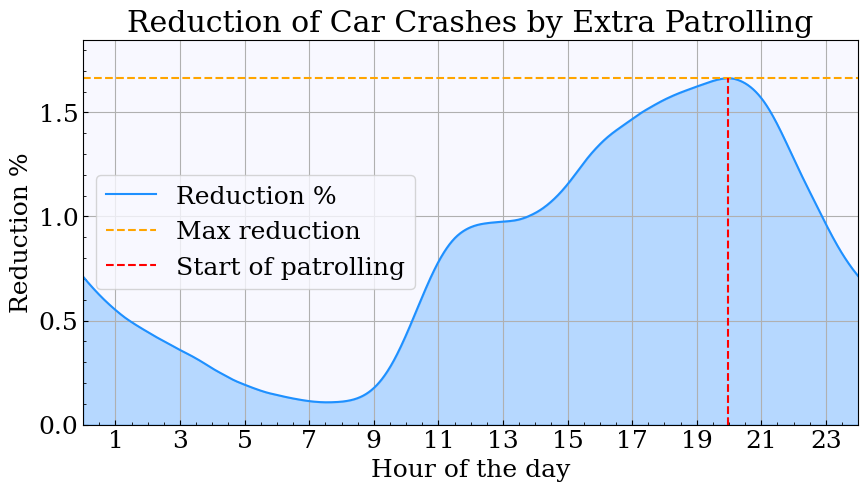

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(t_axis, reduction, label='Reduction %')
ax.fill_between(t_axis, reduction, 0, color='dodgerblue', alpha=0.3)
ax.hlines(max_reduction, 0, 24, color='orange', linestyle='--', label='Max reduction')
ax.vlines(max_reduction_time_start, 0, max_reduction, color='red', linestyle='--', label='Start of patrolling')
ax.set(xlabel='Hour of the day', 
       ylabel='Reduction %', 
       title='Reduction of Car Crashes by Extra Patrolling', 
       xticks=np.arange(1, 25, 2),
       xlim=(0, 24), 
       ylim=(0, 1.85))

ax.legend(loc='center left')

if save_plots:
    plt.savefig('car_crashes_cary_KDE_decreased.png', dpi=300)


# Exercise 2c 

In [19]:
from sklearn.neighbors import KernelDensity

# Remove NaN values
lat = data['lat'][~np.isnan(data['lat'])]
lon = data['lon'][~np.isnan(data['lat'])]
lat = data['lat'][~np.isnan(data['lon'])]
lon = data['lon'][~np.isnan(data['lon'])]
pos = np.stack([lon, lat], axis=1)

h_2D = 0.01

longitude = np.linspace(np.min(lon), np.max(lon), 1000)
latitude = np.linspace(np.min(lat), np.max(lat), 1000)

xx, yy = np.meshgrid(longitude, latitude)  # Create a grid of latitude and longitude
xy_plot = np.stack([xx.ravel(), yy.ravel()], axis=1)

kde_2D = KernelDensity(kernel='epanechnikov', bandwidth=h_2D).fit(pos) # creating density from samples
pdf_2D = np.exp(kde_2D.score_samples(xy_plot))
pdf_2D = pdf_2D.reshape(1000, 1000)

In [35]:
# Define the box
box_lon = np.array([-78.76, -78.72])
box_lat = np.array([35.74, 35.78])

dx = longitude[1] - longitude[0]
dy = latitude[1] - latitude[0]

# Percentage of crashes inside the box
mask_lon = [(longitude > box_lon[0]) & (longitude < box_lon[1])]
mask_lat = [(latitude > box_lat[0]) & (latitude < box_lat[1])]
LON_mask, LAT_mask = np.meshgrid(mask_lon, mask_lat)
box_mask = LON_mask & LAT_mask
box_integral = np.sum(pdf_2D[box_mask] * dx * dy )

print(f'The percentage of crashes inside the box is {box_integral * 100:.2f}%')

The percentage of crashes inside the box is 13.87%


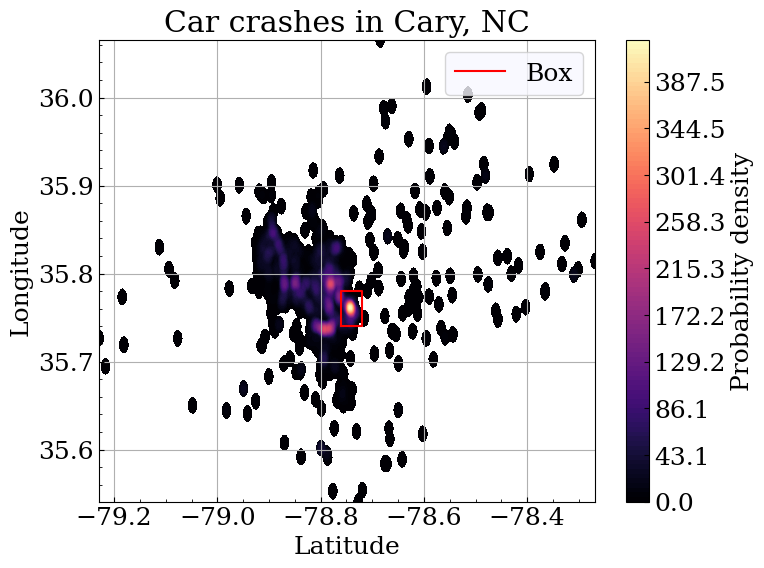

In [53]:
fig, ax = plt.subplots(figsize=(8,6))

# Plotting
contour_levels = np.linspace(pdf_2D.min(), pdf_2D.max(), 100)
sc = ax.contourf(longitude, latitude, pdf_2D, levels=contour_levels, cmap='magma')
fig.colorbar(sc, ax=ax, label='Probability density')

ax.contourf(longitude, latitude, pdf_2D, levels=[0, 0.0001], colors=['white'])


# Plot the box
ax.plot([box_lon[0], box_lon[1], box_lon[1], box_lon[0], box_lon[0]], 
        [box_lat[0], box_lat[0], box_lat[1], box_lat[1], box_lat[0]], 
        color='red', linestyle='-', label='Box')

ax.set(xlabel='Latitude',
         ylabel='Longitude',
         title='Car crashes in Cary, NC')

ax.legend()

if save_plots:
    plt.savefig('car_crashes_cary_2D_KDE.png', dpi=300)

# Exercise 3a

In [60]:
N_trials = 100
N_events = 200

def pdf(t_mark, t, b, sigma):
    exp = 1 / b * np.exp(-t / b)
    gauss = 1 / np.sqrt(2 * np.pi * sigma**2) * np.exp(-(t - t_mark)**2 / (2 * sigma**2))
    return np.convolve(exp, gauss, mode='same')



In [ ]:
b0 = 1
sigma = 0.1
t_mark = np.linspace(0, 10, 1000)

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(t_mark, pdf(t_mark, 1, b0, sigma), label='PDF')


# Exercise 3b 